--- Initializing VP-SDE ---
Running demonstration for VP-SDE...


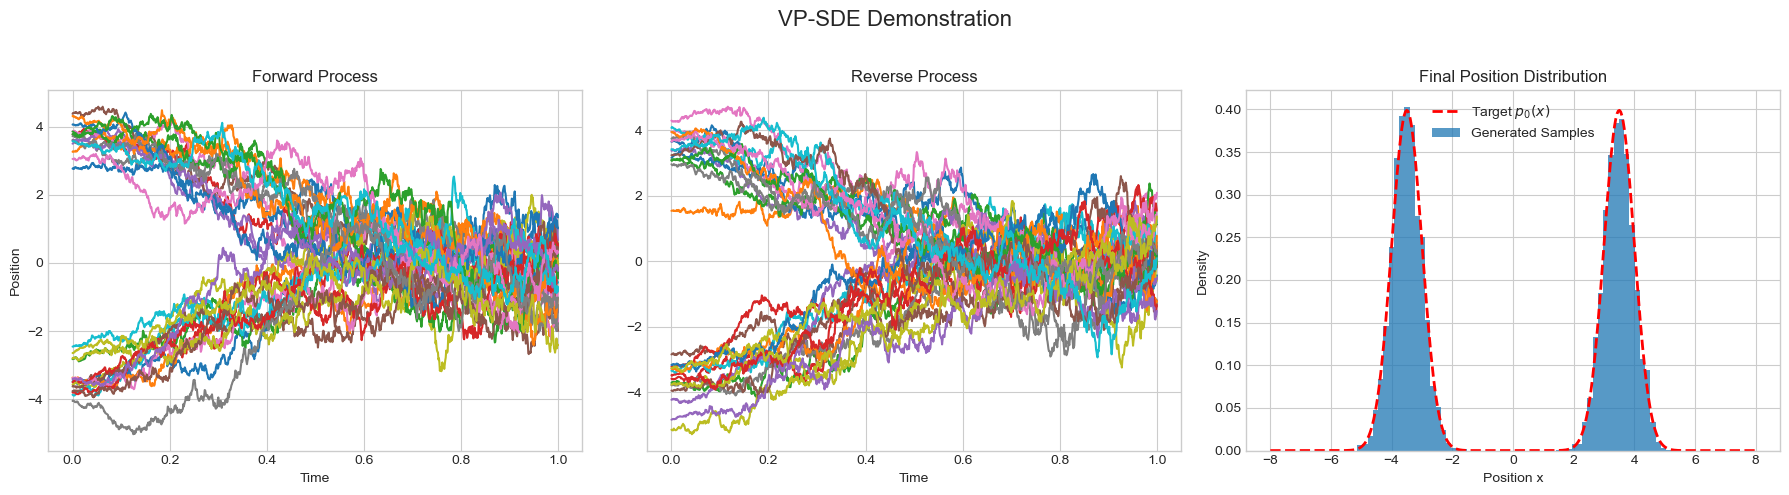



--- Initializing Critically Damped Langevin ---
Pre-computing Critically Damped Langevin analytical moments...
Running demonstration for Critically Damped Langevin...


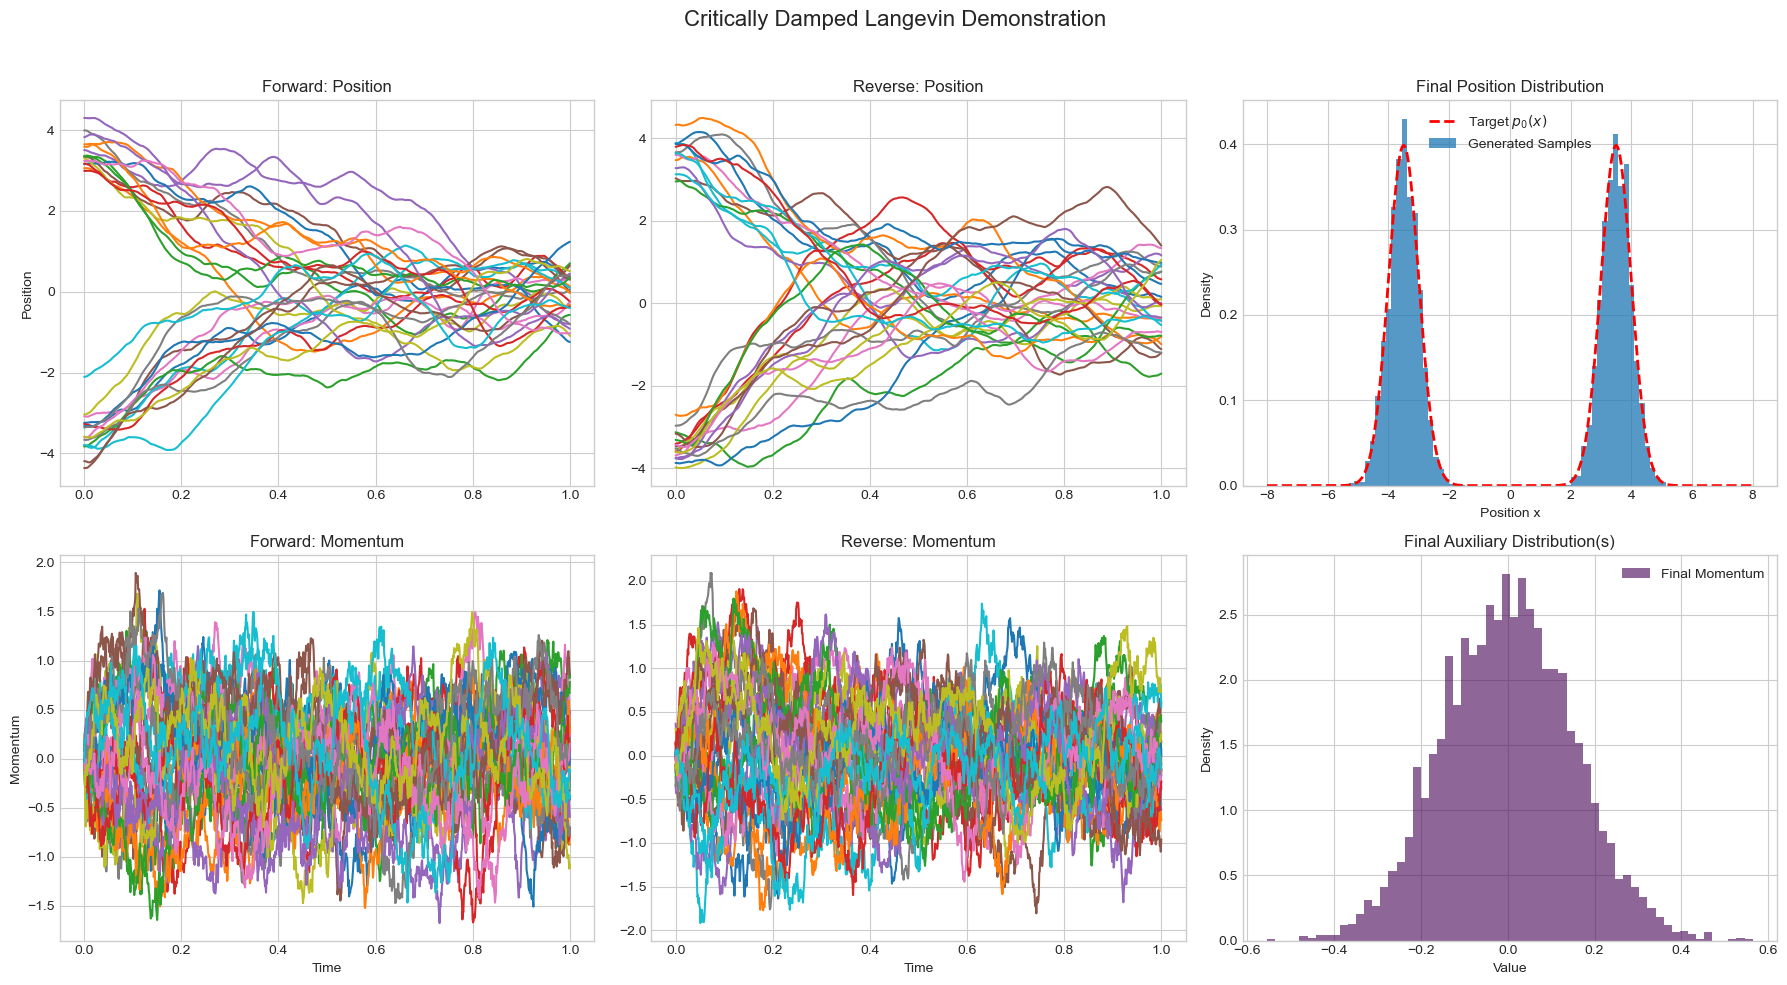



--- Initializing Generalized Langevin Diffusion ---

Running demonstration for Generalized Langevin Diffusion...
Solving forward SDE for Generalized Langevin Diffusion...
Solving forward process analytically for Generalized Langevin Diffusion...
Solving reverse SDE for Generalized Langevin Diffusion...


/Users/rajit906/Downloads/PhD/PhD_Research/Current/gld/diffusion/gld.py:307: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


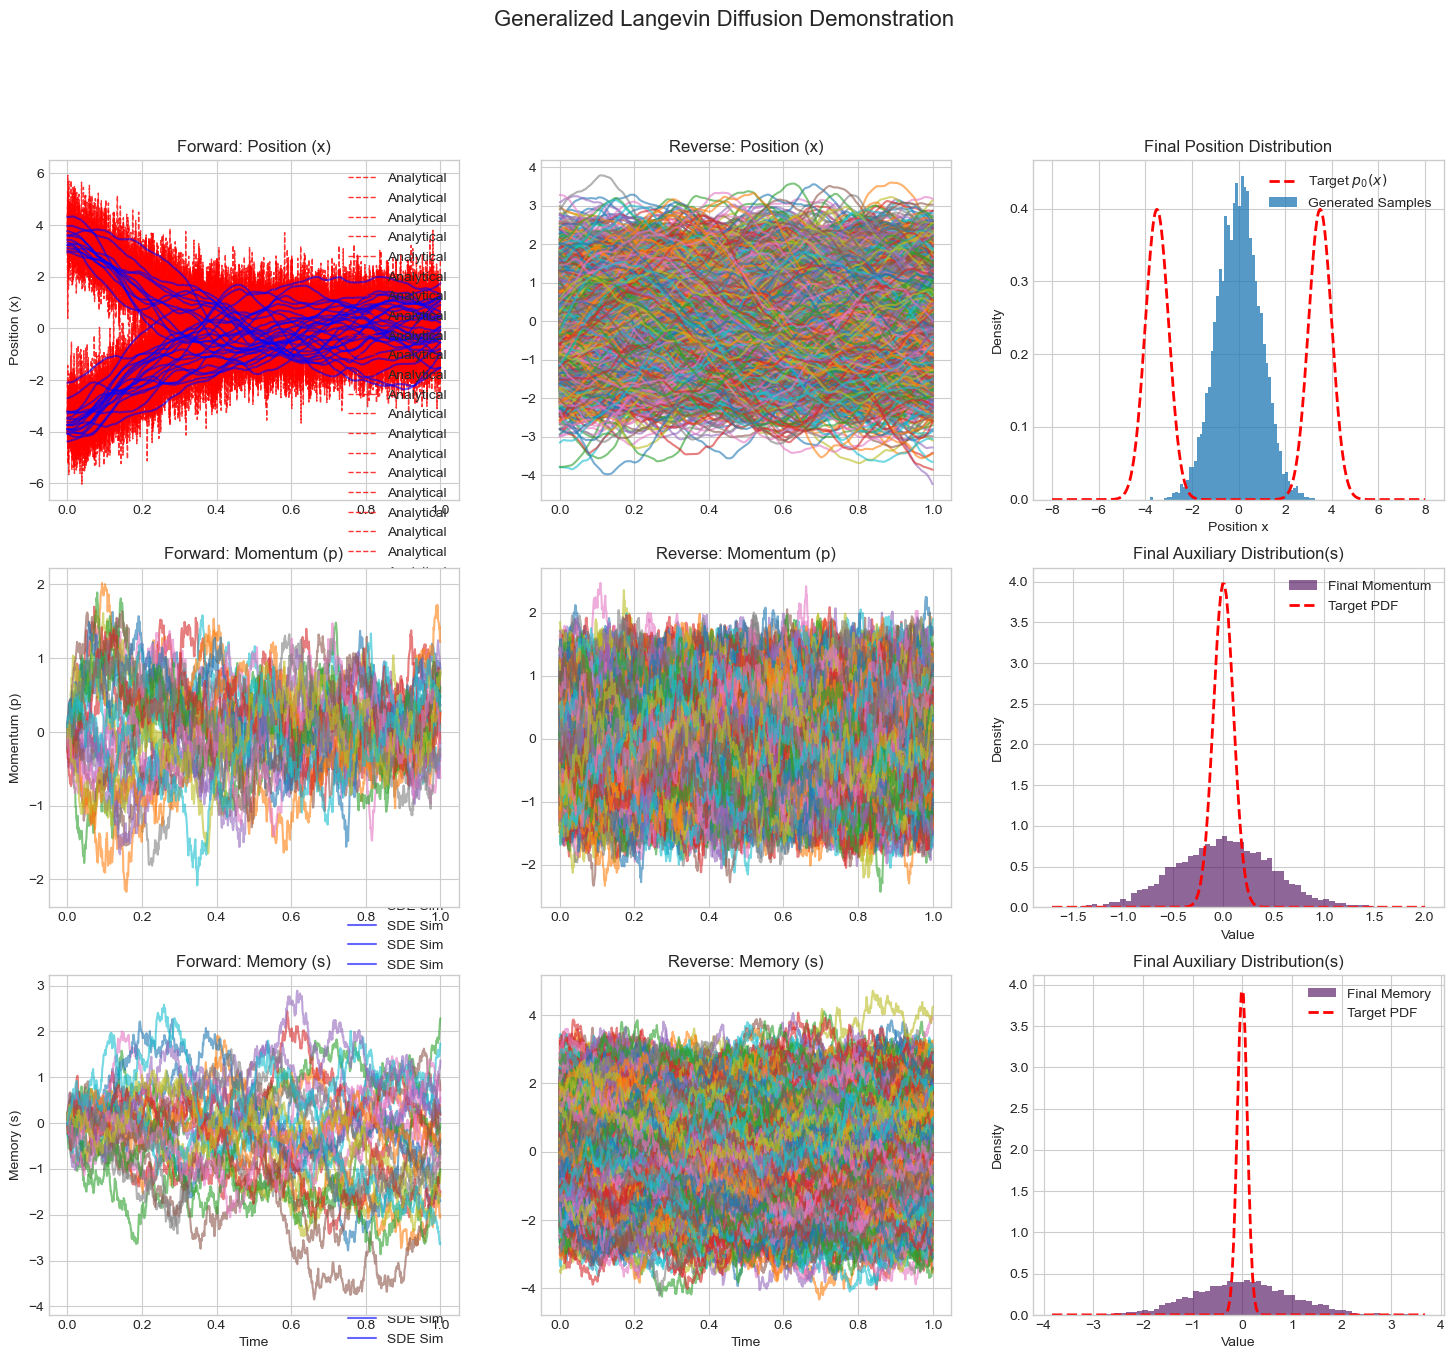

In [ ]:
# TODO: Plot perturbation kernel of momentum and memory
import torch
import matplotlib.pyplot as plt
import numpy as np
from diffusion.vpsde import VPSDE
from diffusion.cld import CriticallyDampedLangevin
from diffusion.gld import GeneralizedLangevinDiffusion

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GMM_PARAMS = {
    'weights': [0.5, 0.5],
    'means': [-3.5, 3.5],
    'stds': [0.5, 0.5]
}

n_plot, n_hist = 30, 5000

vpsde_model = VPSDE(GMM_PARAMS)
vpsde_model.run_demonstration(n_plot, n_hist)

print("\n" + "="*80 + "\n")

cld_model = CriticallyDampedLangevin(GMM_PARAMS)
cld_model.run_demonstration(n_plot, n_hist)

print("\n" + "="*80 + "\n")

gld_model = GeneralizedLangevinDiffusion(GMM_PARAMS)
gld_model.run_demonstration(n_plot, n_hist)

--- Initializing Generalized Langevin Diffusion ---
Precomputing perturbation kernels analytically...
Precomputation finished.
--- Starting Score Function Debugger ---
Generating 50000 forward paths to create empirical distribution...
Solving forward SDE for Generalized Langevin Diffusion...
Analyzing scores at time t = 0.01 (step 10)
Calculating analytical scores...


/Users/rajit906/Downloads/PhD/PhD_Research/Current/gld/diffusion/gld.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_weights = torch.tensor(weights, device=DEVICE).log()


Estimating empirical scores with KDE (this may take a moment)...
Plotting comparison...


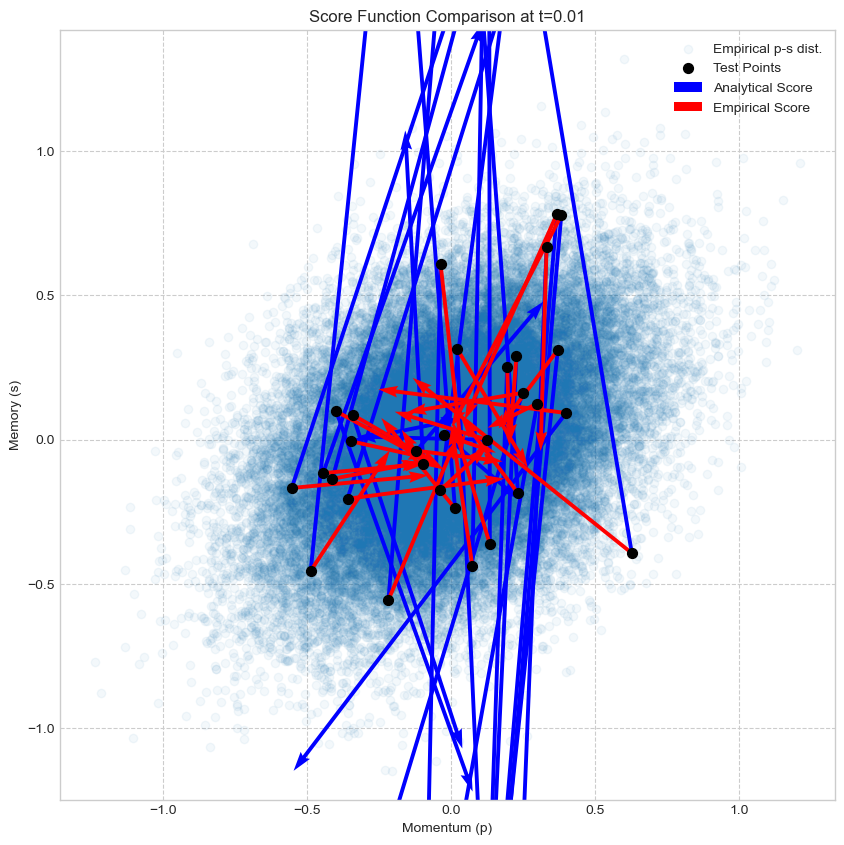

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from diffusion.gld import GeneralizedLangevinDiffusion

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compare_scores(gld_model, n_empirical=50000, n_test=30):
    """
    Compares the analytical score function of a diffusion model with an
    empirical score estimated using Kernel Density Estimation.

    Args:
        gld_model: An instantiated object of the GeneralizedLangevinDiffusion class.
        n_empirical (int): Number of samples to generate for the empirical distribution.
        n_test (int): Number of points to test and plot the scores for.
    """
    print("--- Starting Score Function Debugger ---")
    
    print(f"Generating {n_empirical} forward paths to create empirical distribution...")
    x0_empirical = gld_model._get_initial_samples(n_empirical)
    p0_empirical = torch.randn(n_empirical, device=DEVICE) * np.sqrt(gld_model.p_init_var)
    s0_empirical = torch.randn(n_empirical, device=DEVICE) * np.sqrt(gld_model.s_init_var)
    z0_empirical = torch.stack([x0_empirical, p0_empirical, s0_empirical], dim=-1)
    
    forward_paths = gld_model.solve_forward_sde(z0_empirical)
    
    t_idx = gld_model.n_steps // 100
    time_t = gld_model.ts[t_idx].item()
    print(f"Analyzing scores at time t = {time_t:.2f} (step {t_idx})")
    
    z_t_samples = forward_paths[:, t_idx, :]
    test_points = z_t_samples[:n_test]

    print("Calculating analytical scores...")
    analytical_scores_ps = gld_model._score_fn(test_points, t_idx).cpu().numpy()
    print("Estimating empirical scores with KDE (this may take a moment)...")
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(z_t_samples.cpu().numpy())

    def get_empirical_score_3d(points_z_np):
        """Calculates the 3D score using finite differences on the KDE log-density."""
        epsilon = 1e-5
        log_p = kde.score_samples(points_z_np)
        log_p_dx = kde.score_samples(points_z_np + np.array([epsilon, 0, 0]))
        log_p_dp = kde.score_samples(points_z_np + np.array([0, epsilon, 0]))
        log_p_ds = kde.score_samples(points_z_np + np.array([0, 0, epsilon]))
        
        grad_x = (log_p_dx - log_p) / epsilon
        grad_p = (log_p_dp - log_p) / epsilon
        grad_s = (log_p_ds - log_p) / epsilon
        
        return np.stack([grad_x, grad_p, grad_s], axis=1)

    empirical_scores_3d = get_empirical_score_3d(test_points.cpu().numpy())
    empirical_scores_ps = empirical_scores_3d[:, 1:] # Extract only p and s components

    print("Plotting comparison...")
    test_points_ps_np = test_points[:, 1:].cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.scatter(z_t_samples[:, 1].cpu().numpy(), z_t_samples[:, 2].cpu().numpy(), alpha=0.05, label='Empirical p-s dist.')
    ax.scatter(test_points_ps_np[:, 0], test_points_ps_np[:, 1], color='black', s=50, zorder=5, label='Test Points')
    ax.quiver(test_points_ps_np[:, 0], test_points_ps_np[:, 1], 
              analytical_scores_ps[:, 0], analytical_scores_ps[:, 1], 
              color='blue', scale=20, width=0.005, label='Analytical Score')   
    ax.quiver(test_points_ps_np[:, 0], test_points_ps_np[:, 1], 
              empirical_scores_ps[:, 0], empirical_scores_ps[:, 1], 
              color='red', scale=20, width=0.005, label='Empirical Score')
    ax.set_title(f'Score Function Comparison at t={time_t:.2f}')
    ax.set_xlabel('Momentum (p)')
    ax.set_ylabel('Memory (s)')
    ax.legend()
    ax.grid(True, linestyle='--')
    plt.axis('equal')
    plt.show()


# --- Example Usage ---
GMM_PARAMS = {
    'weights': [0.5, 0.5],
    'means': [-3.5, 3.5],
    'stds': [0.5, 0.5]
}
gld_model = GeneralizedLangevinDiffusion(GMM_PARAMS)
compare_scores(gld_model)